In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
results_path = "/home/obola/repositories/cicero-scm-surrogate/data/20250805_152136/raw/results.pkl"
scenario_path = "/home/obola/repositories/cicero-scm-surrogate/data/20250805_152136/raw/scenarios.pkl"

results = pickle.load(open(results_path, "rb"))
scenarios = pickle.load(open(scenario_path, "rb"))

In [3]:
VAR = "Surface Air Temperature Change"
POLICY_START = 2015

# Rows = scenarios; keep all columns for now
temp_tbl = results[results["variable"] == VAR].set_index("scenario")

def extract_year_matrix(df):
    # Find columns that are years (int or digit-string)
    year_like = []
    for c in df.columns:
        if isinstance(c, (int, np.integer)):
            year_like.append(int(c))
        elif isinstance(c, str) and c.isdigit():
            year_like.append(int(c))
    years_sorted = sorted(set(year_like))
    # Build labels that actually exist in df (prefer the native dtype)
    labels = [y if y in df.columns else str(y) for y in years_sorted]
    # Return matrix with years in ascending order
    Y = df[labels].astype(float)
    return Y, np.array(years_sorted), labels

Y, years_all, year_labels = extract_year_matrix(temp_tbl)

In [4]:
# Split by scenario (no leakage)
scenarios_all = Y.index.tolist()

# Split by scenario (no leakage)
scenarios_all = Y.index.tolist()
train_scen, test_scen = train_test_split(scenarios_all, test_size=0.2,
                                         random_state=42, shuffle=True)
# Eval years: predict up to last-1
mask_eval = (years_all >= POLICY_START) & (years_all < years_all.max())
idx_eval = np.where(mask_eval)[0]

### 2. Persistance baseline

In [5]:
def eval_persistence_oracle(Y_df, idx_eval):
    y_true, y_pred = [], []
    mat = Y_df.to_numpy()  # rows=scenarios, cols=years in 'year_labels' order
    for r in range(mat.shape[0]):
        y_true.extend(mat[r, idx_eval + 1])
        y_pred.extend(mat[r, idx_eval])
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"Persistence (oracle) R2: {r2:.4f} K")
    print(f"Persistence (oracle) RMSE: {rmse:.4f} K")
    return y_true, y_pred

persist_y, persist_hat = eval_persistence_oracle(Y.loc[scenarios_all, year_labels], idx_eval)

Persistence (oracle) R2: 0.9890 K
Persistence (oracle) RMSE: 0.0240 K


In [6]:
def plot_persistence_samples(
    Y,                # DataFrame: rows=scenarios, cols=years (int or str), ascending
    years_all,        # np.array[int] aligned with Y's columns
    scenarios,        # list[str] to sample from (e.g., test_scen)
    n_samples=4,
    start_year=2000,  # <- true series starts here
    policy_start=2015,
    savepath=None
):
    # map year ints to existing column labels (str vs int)
    def _label(df, y): return y if y in df.columns else str(y)
    year_labels = [_label(Y, y) for y in years_all]

    # evaluation positions: years t where we predict t+1, with t >= policy_start
    mask_eval = (years_all >= policy_start) & (years_all < years_all.max())
    idx_eval = np.where(mask_eval)[0]
    years_target = years_all[idx_eval + 1]  # x for y_true(t+1) and y_pred(t+1)

    # sample scenarios
    rng = random.Random()
    chosen = rng.sample(scenarios, k=min(n_samples, len(scenarios)))

    # subset and cast
    Y_sub = Y.loc[chosen, year_labels].astype(float)     # S × T
    series_mat = Y_sub.to_numpy()

    # true (at targets) and persistence predictions
    y_true_mat = series_mat[:, idx_eval + 1]             # S × Teval
    y_pred_mat = series_mat[:, idx_eval]                 # S × Teval (ŷ(t+1)=y(t))

    # plot
    plt.figure(figsize=(10, 6))
    cmap = plt.get_cmap("tab10")

    # mask for full true series starting at start_year
    full_mask = years_all >= start_year
    years_full = years_all[full_mask]

    for i, scen in enumerate(chosen):
        col = cmap(i % 10)
        full_true = series_mat[i, full_mask]            # true ΔT from start_year..end
        # plot true (solid) from start_year
        plt.plot(years_full, full_true, color=col, lw=2.0, label=f"{scen} — true ΔT")
        # plot persistence predictions (dashed) only at eval targets
        plt.plot(years_target, y_pred_mat[i], color=col, lw=1.6, ls="--",
                 label=f"{scen} — persistence ŷ(t+1)")

    # vertical marker
    plt.axvline(policy_start, color="gray", ls="--", lw=1, alpha=0.8)

    plt.xlim(max(start_year, years_all.min()), years_all.max())
    plt.xlabel("Year")
    plt.ylabel("Surface Air Temperature Change (K)")
    plt.title("Persistence (oracle): sampled scenarios — true ΔT vs. ŷ(t+1)")
    plt.legend(frameon=True, fontsize=8, ncol=2, loc = "upper left")
    plt.tight_layout()

    if savepath:
        os.makedirs(os.path.dirname(savepath), exist_ok=True)
        plt.savefig(savepath, dpi=300, bbox_inches="tight")
    plt.show()


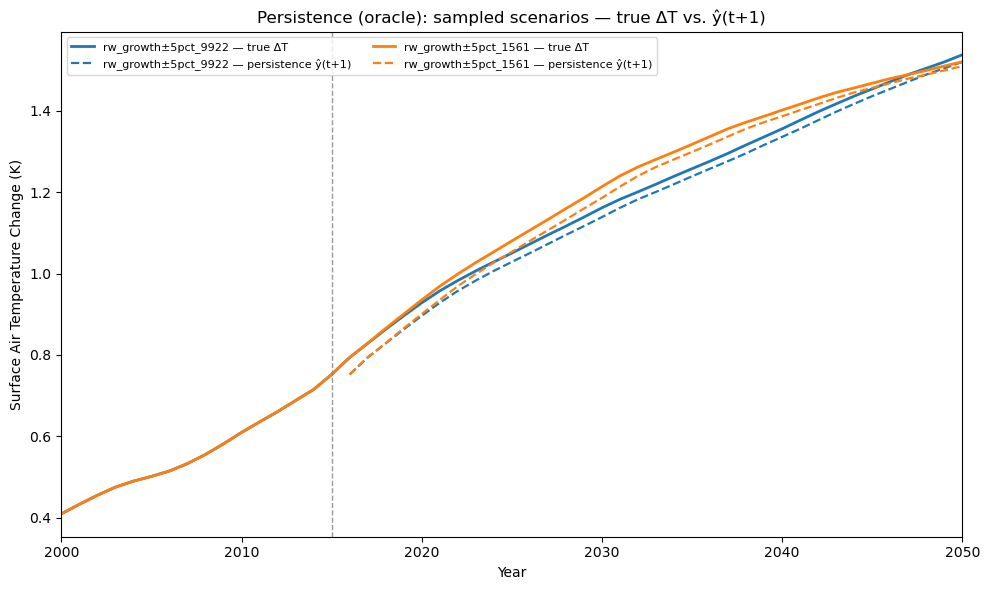

In [7]:
plot_persistence_samples(
    Y=Y, years_all=years_all, scenarios=scenarios_all,
    n_samples=2, start_year=2000,
    savepath="plots/persistence_samples.pdf"
)

## 3. Auto-regressive

In [8]:
def fit_global_ar_ols(Y_train_df: pd.DataFrame, p: int = 5, ridge: float = 1e-6):
    """
    Fit one AR(p) model on the concatenation of all training scenarios.
    Y_train_df: rows=scenarios, cols=years (ascending, strings or ints)
    Returns (a, b) where y_t ≈ a + sum_{k=1..p} b_k * y_{t-k}.
    """
    # ensure float and consistent column order
    Y_train = Y_train_df.copy()
    if not np.issubdtype(Y_train.columns.dtype, np.number):
        # convert columns to int if they are strings like '1900'
        Y_train.columns = Y_train.columns.astype(int)
    Y_train = Y_train.sort_index(axis=1)
    M = Y_train.to_numpy(dtype=float)  # shape: (n_scen, T)

    # Build design matrix across ALL training scenarios
    T = M.shape[1]
    if T <= p:
        raise ValueError("Not enough time steps to fit AR(p).")

    # For each row (scenario) and each valid time t (p..T-1), make one training sample
    X_rows = []
    z_rows = []
    for r in range(M.shape[0]):
        series = M[r]
        for t in range(p, T):
            # features: [1, y_{t-1}, ..., y_{t-p}]
            feats = [1.0] + [series[t-k] for k in range(1, p+1)]
            X_rows.append(feats)
            z_rows.append(series[t])

    X = np.asarray(X_rows, dtype=float)      # (N, p+1)
    z = np.asarray(z_rows, dtype=float)      # (N,)

    # Ridge-stabilized normal equations
    XtX = X.T @ X + ridge * np.eye(p+1)
    Xtz = X.T @ z
    beta = np.linalg.solve(XtX, Xtz)
    a = float(beta[0])
    b = beta[1:].astype(float)               # shape (p,)
    return a, b


# ---------- 2) Predict with the fixed AR coefficients (no re-fit) ----------
def ar_predict_next_with_coeffs(series: np.ndarray, coeffs, t: int):
    """
    Given a full temperature series (1D) and fixed AR coeffs, predict y_{t+1}.
    Uses true lags y_t, y_{t-1}, ..., y_{t-p+1}. Requires t >= p-1.
    """
    a, b = coeffs
    p = len(b)
    if t < p-1:
        raise ValueError("t must be >= p-1 to have enough lags.")
    lags = np.array([series[t-k] for k in range(p)], dtype=float)  # y_t, y_{t-1}, ...
    return float(a + np.dot(b, lags))


# ---------- 3) Evaluate on a split WITHOUT refitting ----------
def eval_global_ar_oracle(Y_df: pd.DataFrame,
                          coeffs,
                          idx_eval: np.ndarray,
                          years_all: np.ndarray):
    """
    Evaluate fixed AR on a set of scenarios/years.
    Y_df: rows=scenarios, cols=years (ascending, strings or ints)
    idx_eval: indices into years_all for t where we predict t+1
    years_all: array of all years corresponding to Y_df columns (ints)
    Returns: rmse, r2, y_true_all, y_pred_all
    """
    Y = Y_df.copy()
    # align columns to years_all order
    if not np.issubdtype(Y.columns.dtype, np.number):
        Y.columns = Y.columns.astype(int)
    Y = Y.reindex(columns=years_all, copy=False)
    M = Y.to_numpy(dtype=float)

    y_true_all, y_pred_all = [], []
    for r in range(M.shape[0]):
        series = M[r]
        for i in idx_eval:
            # predict next year i+1 using true lags up to year i
            pred = ar_predict_next_with_coeffs(series, coeffs, t=i)
            y_pred_all.append(pred)
            y_true_all.append(series[i+1])

    y_true_all = np.asarray(y_true_all, dtype=float)
    y_pred_all = np.asarray(y_pred_all, dtype=float)
    rmse = float(np.sqrt(mean_squared_error(y_true_all, y_pred_all)))
    r2   = float(r2_score(y_true_all, y_pred_all))

    print(f"AR(p={len(coeffs[1])}) oracle: RMSE={rmse:.4f}  R^2={r2:.4f}")
    return y_true_all, y_pred_all

In [9]:
Y_train = Y.loc[train_scen, years_all]
coeffs = fit_global_ar_ols(Y_train, p=50, ridge=1e-6)

In [10]:
y_true_test, y_pred_test = eval_global_ar_oracle(
    Y.loc[test_scen, years_all], coeffs, idx_eval, years_all
)

AR(p=50) oracle: RMSE=0.0017  R^2=0.9999


In [11]:
def plot_ar_samples_fixed(
    Y,                # DataFrame: rows=scenarios, cols=years (int or str), ascending
    years_all,        # np.array[int] aligned with Y’s columns (sorted ascending)
    scenarios,        # list[str] (e.g., test_scen)
    coeffs,           # (a, b) from fit_global_ar_ols on TRAIN ONLY
    n_samples=4,
    start_year=2000,  # true curve starts here
    policy_start=2015,
    savepath=None,
):
    # Map int years to actual column labels (int or str) present in Y
    def _label(df, y): return y if y in df.columns else str(y)
    year_labels = [_label(Y, y) for y in years_all]

    # Eval years: predict t+1 for all t >= policy_start and t < max(year)
    mask_eval   = (years_all >= policy_start) & (years_all < years_all.max())
    idx_eval    = np.where(mask_eval)[0]
    years_pred  = years_all[idx_eval + 1]  # targets

    # Sample scenarios reproducibly
    rng = np.random.default_rng()
    chosen = rng.choice(np.array(scenarios), size=min(n_samples, len(scenarios)), replace=False)

    # Subset and ensure float dtype
    Y_sub = Y.loc[chosen, year_labels].astype(float)   # shape: S × T
    mat   = Y_sub.to_numpy()

    # -------- Evaluate fixed AR(p) oracle (no re-fit) --------
    y_true_flat, y_pred_flat = eval_global_ar_oracle(
        Y_sub, coeffs, idx_eval, years_all
    )

    # Reshape per-scenario for plotting
    S, T_eval = len(chosen), len(idx_eval)
    y_true = y_true_flat.reshape(S, T_eval)
    y_pred = y_pred_flat.reshape(S, T_eval)

    # Plot
    plt.figure(figsize=(10, 6))
    cmap = plt.get_cmap("tab10")

    # True series from start_year
    mask_full  = years_all >= start_year
    years_full = years_all[mask_full]

    for i, scen in enumerate(chosen):
        col = cmap(i % 10)
        true_series = mat[i, mask_full]                 # true ΔT (K or °C, consistent with data)
        plt.plot(years_full, true_series, color=col, lw=2.0, label=f"{scen} — true ΔT")
        # AR(p) one-step predictions at years_pred
        plt.plot(years_pred, y_pred[i], color=col, lw=1.6, ls="--", label=f"{scen} — AR({len(coeffs[1])}) ŷ(t+1)")

    plt.axvline(policy_start, color="gray", ls="--", lw=1, alpha=0.8)
    plt.xlim(max(start_year, years_all.min()), years_all.max())
    plt.xlabel("Year")
    plt.ylabel("Surface Air Temperature Change")
    plt.legend(frameon=True, fontsize=8, ncol=2, loc="upper left")
    plt.tight_layout()

    if savepath:
        os.makedirs(os.path.dirname(savepath), exist_ok=True)
        plt.savefig(savepath, dpi=300, bbox_inches="tight")
    plt.show()


AR(p=50) oracle: RMSE=0.0017  R^2=0.9999


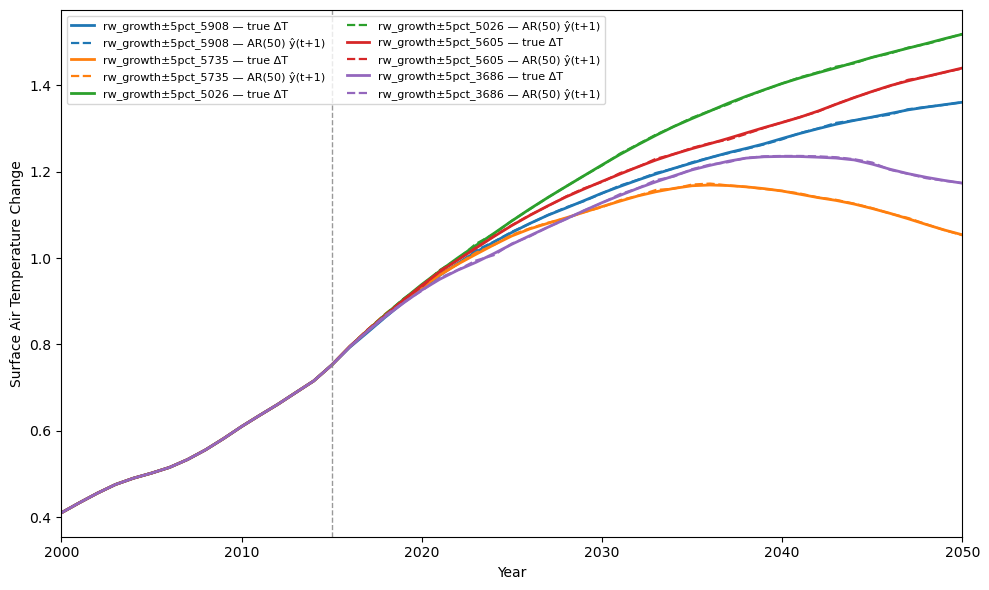

In [12]:
# 2) Plot + evaluate on TEST (no refit)
plot_ar_samples_fixed(
    Y=Y, years_all=years_all, scenarios=test_scen, coeffs=coeffs,
    n_samples=5, start_year=2000, policy_start=2015,
    savepath="plots/ar50_oracle_samples.pdf")

### 3. Comparison plot

In [17]:
def plot_oracle_single_method(
    Y,
    years_all,
    chosen,             # pass pre-chosen scenarios
    preds,              # predictions array S × T_eval
    method_label,       # "AR(50)" or "Persistence"
    start_year=2000,
    policy_start=2015,
    savepath=None
):
    mask_full  = years_all >= start_year
    years_full = years_all[mask_full]

    mask_eval  = (years_all >= policy_start) & (years_all < years_all.max())
    idx_eval   = np.where(mask_eval)[0]
    years_pred = years_all[idx_eval + 1]

    Y_sub = Y.loc[chosen].astype(float)
    mat   = Y_sub.to_numpy()
    S     = len(chosen)

    plt.figure(figsize=(10, 6))
    cmap = plt.get_cmap("tab10")

    for i in range(S):
        scen_label = f"S{i+1}"
        col = cmap(i % 10)
        plt.plot(years_full, mat[i, mask_full], color=col, lw=2.0,
                 label=f"{scen_label} — True", alpha=0.35)
        plt.plot(years_pred, preds[i], color=col, lw=1.6, ls="--",
                 label=f"{scen_label} — {method_label}")

    plt.axvline(policy_start, color="gray", ls="--", lw=1, alpha=0.8)
    plt.xlim(max(start_year, years_all.min()), years_all.max())
    plt.xlabel("Year", fontsize=14)
    plt.ylabel("Surface Air Temperature Change (°K)", fontsize=14)
    plt.legend(frameon=True, fontsize=14, ncol=3, loc="upper left")
    plt.tight_layout()

    if savepath:
        os.makedirs(os.path.dirname(savepath), exist_ok=True)
        plt.savefig(savepath, dpi=300, bbox_inches="tight")
    plt.show()



AR(p=50) oracle: RMSE=0.0015  R^2=1.0000


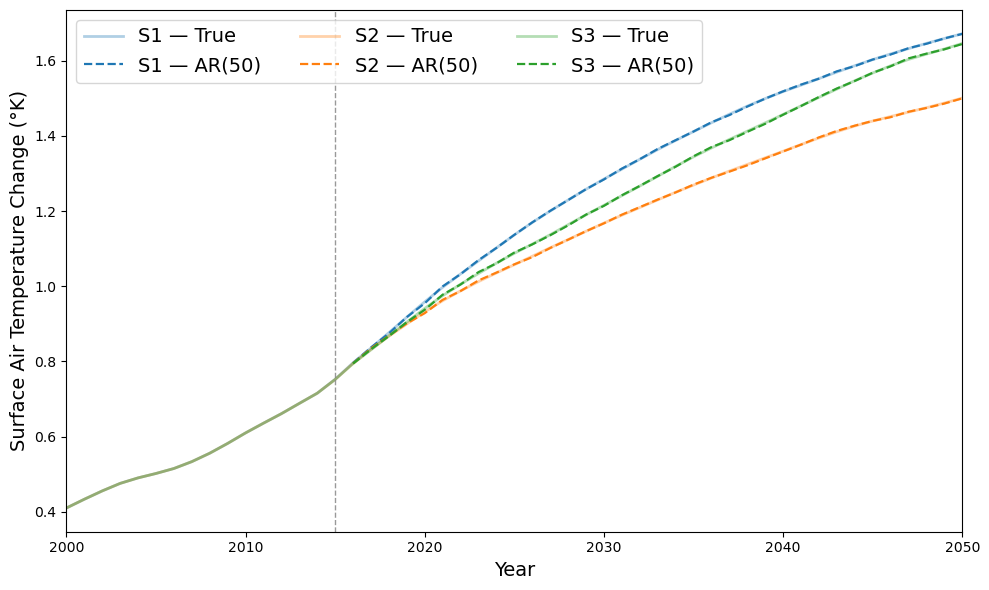

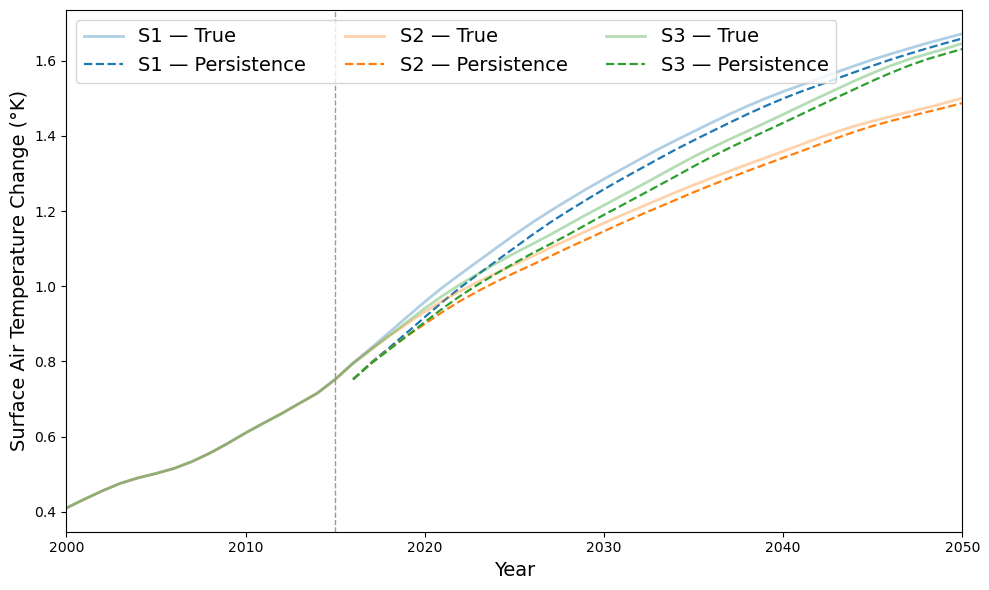

In [18]:
# ------------------- usage -------------------
# Choose scenarios once
rng = np.random.default_rng(14)
chosen = rng.choice(np.array(test_scen), size=3, replace=False)

# Compute AR predictions
_, y_pred_flat_ar = eval_global_ar_oracle(Y.loc[chosen, years_all], coeffs, idx_eval, years_all)
y_ar = y_pred_flat_ar.reshape(len(chosen), len(idx_eval))

# Compute persistence predictions
mat_sub = Y.loc[chosen, years_all].to_numpy()
y_persistence = np.array([[mat_sub[i, idx] for idx in idx_eval] for i in range(len(chosen))])

# Plot separately
plot_oracle_single_method(Y, years_all, chosen, y_ar, "AR(50)", savepath="plots/ar_only.pdf")
plot_oracle_single_method(Y, years_all, chosen, y_persistence, "Persistence", savepath="plots/persistence_only.pdf")